<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/%EC%9A%B0%EA%B2%BD%ED%99%94_sts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**

## **과제 목표**

- 두 개의 한국어 문장을 입력받아 두 문장의 의미적 유사도를 출력
- regression task (0 ≤ target ≤ 5)

## **학습 데이터셋(Dataset description)**

- [KLUE-STS](https://klue-benchmark.com/tasks/67/data/download)
  - AIRBNB (에어비앤비 리뷰)
  - policy (정책 뉴스)
  - paraKOQC (스마트홈 쿼리)

  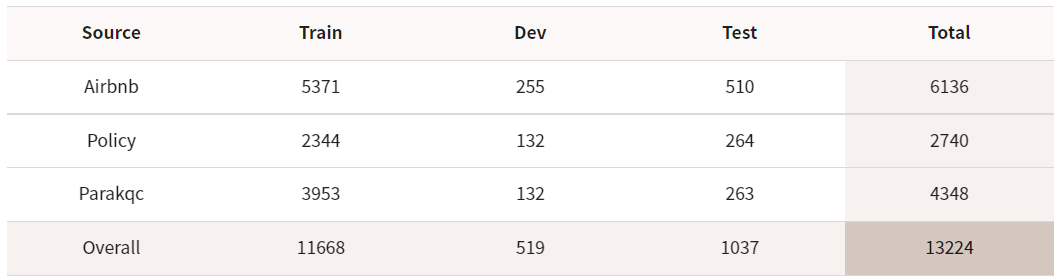

## **과제 결과물**
- 학습된 모델 (모델 자유 선택) (train set만 사용해 학습)
- 학습 방식 보고서
 - 어떤 모델을 선택했나
 - 어떻게 파라미터를 튜닝했나
 - 어떤 훈련 과정을 거쳤는가
- dev set score (F1)
- 문장 유사도를 출력하는 API (프레임워크 자유 선택)

## **설치 및 설정(Set up)**

In [1]:
# Hugging Face의 트랜스포머 모델 설치
!pip install transformers
!pip install sentence_transformers datasets
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 라이브러리
import os
import sys
import re
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import logging
import time
from datetime import datetime

import torch
import tensorflow as tf

from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

In [3]:
# logger
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

- [SBERT-only-STS-training](https://colab.research.google.com/drive/1CJqg1LdNU0eMvcWYjBAE4RtDKysPKBae?usp=sharing#scrollTo=0-NWkVzvHxoe)

In [4]:
# model : klue/roberta-base 사용
pretrained_model_name = 'klue/roberta-base'
sts_num_epochs = 4
train_batch_size = 32

sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

## **데이터셋 불러오기(Load Dataset)**
- STS 데이터는 두 개의 문장 쌍과 이 두 문장 사이의 유사도 점수로 구성됨.
- STS데이터를 학습하여 문장과 문장간 서로 얼마나 유사한지를 예측.

In [5]:
# KLUE-STS 데이터셋 다운로드
dataset = load_dataset('klue', 'sts')

2022-05-24 20:08:51 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# 데이터셋 구조
dataset

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})

In [7]:
# 데이터셋 중 train 첫째 줄 내용
dataset['train'][0]

{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [8]:
# 데이터셋 중 validation 첫째 줄 내용
dataset['validation'][0]

{'guid': 'klue-sts-v1_dev_00000',
 'labels': {'binary-label': 1, 'label': 4.9, 'real-label': 4.857142857142857},
 'sentence1': '무엇보다도 호스트분들이 너무 친절하셨습니다.',
 'sentence2': '무엇보다도, 호스트들은 매우 친절했습니다.',
 'source': 'airbnb-rtt'}

In [9]:
# klue_sts_train : 훈련용 / klue_sts_test : 테스트용
# test 데이터가 없어서 validation을 test로 사용
klue_sts_train = dataset['train']
klue_sts_test = dataset['validation']

## **데이터 전처리(Data Preprocessing)**
- 결측값 확인 후 제거
- 중복 행 확인 후 제거
- 데이터 정제
 - 특수문자 제거
 - 한글, 영어, 숫자를 제외한 모든 문자열 제거

- InputExample() 클래스를 통해, 두 개의 문장 쌍과 라벨을 묶어 모델이 학습할 수 있는 형태로 변환
- 배치학습을 위해 train 데이터를 DataLoader()로 묶음
- EmbeddingSimilarityEvaluator() 을 통해 모델 평가 시 사용할 test 검증기 만듦

In [10]:
def make_sts_input_example(dataset):
    ''' 
    Transform to InputExample
    ''' 
    input_examples = []
    for i, data in enumerate(dataset):
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        score = (data['labels']['label']) / 5.0  # normalize 0 to 5
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=score))

    return input_examples

In [11]:
sts_train_examples = make_sts_input_example(klue_sts_train)
sts_test_examples = make_sts_input_example(klue_sts_test)

In [12]:
# Train Dataloader
train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=train_batch_size,
)

# test 검증기
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-test",
)

## **EDA(Exploratory Data Analysis)**
- 데이터 분석(가설 검정??)
- 시각화

## **사전학습모델 불러오기(Load Pretrained Model)**
- 임베딩모델 불러오기
- Mean Pooling(평균 풀링) 사용

In [13]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path=pretrained_model_name,  # klue/roberta-base 사용
    max_seq_length=256,
    do_lower_case=True
)

# Mean Pooling(평균 풀링)만 사용. -> 문장의 모든 토큰 임베딩 벡터를 풀링함.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

2022-05-24 20:08:54 - Use pytorch device: cuda


## **모델 훈련(Model Training)**

In [14]:
"""
sts_num_epochs = 4
train_batch_size = 32
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
"""

# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-24 20:08:54 - Warmup-steps: 146


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-24 20:21:31 - Save model to output/training_sts-klue-roberta-base-2022-05-24_20-08-50


## **모델 평가(Model Evaluation)**

In [15]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-24 20:21:32 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-24 20:21:34 - Cosine-Similarity :	Pearson: 0.8855	Spearman: 0.8847
2022-05-24 20:21:34 - Manhattan-Distance:	Pearson: 0.8838	Spearman: 0.8803
2022-05-24 20:21:34 - Euclidean-Distance:	Pearson: 0.8843	Spearman: 0.8805
2022-05-24 20:21:34 - Dot-Product-Similarity:	Pearson: 0.8741	Spearman: 0.8686


0.884739088370507